In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import constants

import skfmm

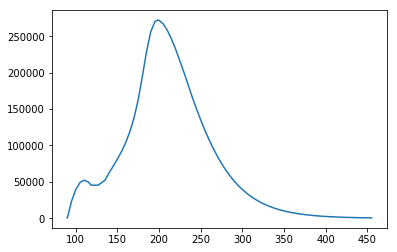

In [3]:
# Load an ionogram to get charge density as a function of height
with open('data/ukssd/NHPC_Profiles-20190126120000-30611') as fi:
    hli = 0    # header line index
    rep = []
    loc_name = ''
    loc_id = ''
    date = ''
    time = ''
    
    for line in fi:
        if hli == 0:
            [loc_name, loc_id, date, time] = line.split()
            loc_id = loc_id[1:-2]
            hli = 1
            continue
            
        elif hli < 4:
            hli += 1
            continue
        
        elif line == '===\n':
            ofn = 'data/processed/' + loc_id + '_' + date + '_' + time + '.csv'
            if len(rep) > 0 and rep[0] != '\n':
                with open(ofn, 'w') as fo:
                    fo.write('Height,Frequency,Density\n')
                    for ol in rep:
                        op = ''
                        for os in ol.split():
                            op += os + ','
                        fo.write(op[0:-1] + '\n')
            hli = 0
            rep.clear()
        else:
            rep.append(line)

df = pd.read_csv('data/processed/mo155_2019-01-26_12:01:00.csv')
plt.plot(df['Height'],df['Density'])

/home/pskim2001/anaconda3/envs/irss/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app
/home/pskim2001/anaconda3/envs/irss/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt


50.0


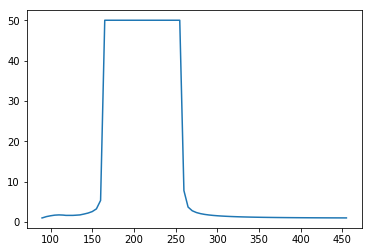

In [60]:
E_CHARGE = 1.60217662e-19 # coulombs
E_MASS = 9.109e-31 # kg
EPSILON_0 = 8.854187817e-12 # F m^−1


def count2omega_p(count):
    return np.sqrt(count * 10e5 * (E_CHARGE ** 2) / EPSILON_0 / E_MASS)


def freq2omega(freq):
    return 2 * np.pi * freq
    

def omegas2perm(omega_p, omega):
    return np.sqrt(1 - (omega_p ** 2) / (omega ** 2))

def perm2n(perm):
    return np.sqrt(perm)

def ind(omega_p, omega):
    return (1/np.sqrt(1 - (omega_p/omega)))

# Assume for now we're TX at 10 MHz
# Calculate index of refraction
tx_freq = 3e6 # hz
perm = omegas2perm(count2omega_p(df['Density']), freq2omega(tx_freq))
#index = perm2n(perm)
index = ind(count2omega_p(df['Density']), freq2omega(tx_freq))
# index = np.nan_to_num(index)
index[np.isnan(index)] = 50
plt.plot(df['Height'],index)
print(index[30])

# Expand n(h) to n(x,y)
i2d = np.tile(np.array([index]).transpose(), (1, len(index)))
#plt.plot(df['Height'], i2d)
#plt.imshow(i2d)

# Noise n(x,y)

79
[array([[1., 1.],
       [1., 1.]]), array([[ 1.        ,  1.        ],
       [12.63857343, 10.62037702]]), array([[12.63857343, 10.62037702],
       [23.53359848, 18.45940294]]), array([[23.53359848, 18.45940294],
       [36.16953364, 26.87894987]]), array([[36.16953364, 26.87894987],
       [48.75452492, 35.38341478]]), array([[48.75452492, 35.38341478],
       [61.10593924, 44.22628669]]), array([[61.10593924, 44.22628669],
       [73.29447724, 53.29461178]]), array([[73.29447724, 53.29461178],
       [85.5049366 , 62.33277492]]), array([[85.5049366 , 62.33277492],
       [97.89770806, 71.11589771]]), array([[ 97.89770806,  71.11589771],
       [110.67628062,  79.31178059]]), array([[110.67628062,  79.31178059],
       [124.01141613,  86.55001655]]), array([[124.01141613,  86.55001655],
       [137.90770707,  92.6199108 ]]), array([[137.90770707,  92.6199108 ],
       [152.30693529,  97.28640246]]), array([[152.30693529,  97.28640246],
       [152.30693529,  97.28640246]]), arra

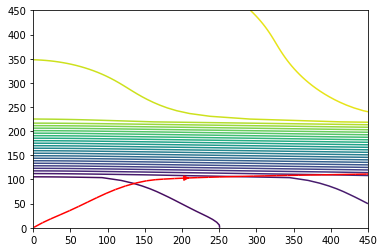

In [61]:
X, Y = np.meshgrid(np.linspace(0,450,len(index)), np.linspace(0,450,len(index)))
phi = (X)**2+(Y)**2 
# phi = X**2+Y**2
print(len(index))
tt = skfmm.travel_time(phi, constants.c * (1/i2d), dx=0.05/500)
gradx, grady = np.gradient(tt)


#plt.imshow(tt)
#plt.scatter([phi[0]], c[phi[1]], s=100, facecolors="none", edgecolors="orange", lw=5)

#plt.plot()
#plt.contour(X,Y,phi,30, colors ='red')
seed_points = np.array([[1],[1]])
plt.contour(X,Y,tt, 30)
stream = plt.streamplot(X,Y,gradx,grady,color='r',start_points=seed_points.T)
path = stream.lines.get_segments()

dist = 0
travelTime = 0
for x in path:
    dist_inc = np.sqrt((x[1][0]-x[0][0])**2 + (x[1][1]-x[0][1])**2)
    dist += dist_inc
    index_x = int((x[1][0] + x[0][0]) / 2 * len(index) / 450)
    index_y = int((x[1][1] + x[0][1]) / 2 * len(index) / 450)
    speed = 1/i2d[index_x][index_y]*constants.c
    travelTime += dist_inc * 1000 / speed

print(path)

print(dist)
print(travelTime)
#plt.quiver(X,Y,gradx, grady)


In [21]:
init_x = 1
init_y = 1

new_x = init_x
new_y = init_y

pos_x = np.empty(1)
pos_y = np.empty(1)
temp_x = 0 
temp_y = 0
pos_x = np.append(pos_x, new_x)
pos_y = np.append(pos_y, new_y)
count = 0

while(new_x < len(index)-1 and new_y < len(index) - 1):
    while(np.int(temp_x) != new_x):
        temp_x += gradx[new_x][new_y]*450/len(index)
        temp_y += grady[new_x][new_y]*450/len(index)
        pos_x = np.append(pos_x, temp_x)
        pos_y = np.append(pos_y, temp_y)
        count += 1
        if(count % 100000 == 0):
            print(count)
            print(temp_x, temp_y)
    
    new_x = np.int(temp_x*len(index)/450)
    new_y = np.int(temp_y*len(index)/450)
    
    

plt.scatter(pos_x,pos_y)

100000
1.6260258062027615e-06 1.4774415163049004e-06


KeyboardInterrupt: 

In [ ]:
travelTime = 0
timeArray = np.zeroes(1)
previousTime = 0
for i in range(len(pos_x)-1):
    timeDifference = np.sqrt((pos_x[i+1]^2 + pos_y[i+1]^2) - (pos_x[i]^2 + pos_y[i]^2)) / (constants.c*index[i])
    travelTime += timeDifference
    timeArray = np.append(timeArray, previousTime + timeDifference)
    previousTime += timeDifference
pos_satellite = np.zeroes(2)
satellite_radius = np.linalg.norm(pos_satellite)
Earth_Vector = np.zeroes(2)
ray_vector = np.zeroes(2)
omega = 0
pos_x_intersection = np.zeroes(1)
pos_y_intersection = np.zeroes(1)
"""for i in timeArray:
    if(pos_x[i] == satellite_radius*np.cos(omega*timeArray[i]) and pos_y[i] == satellite_radius*np.sin(omega*timeArray[i])):
        pos_x_intersection = pos_x[i]
        pos_y_intersection = pos_y[i]*/"""
for i in range(len(pos_x)):
    ray_vector[0] = pos_x[i]
    ray_vector[1] = pos_y[i]
    if(np.linalg.norm(ray_vector + Earth_Vector == satellite_radius)):
        pos_x_intersection = np.append(pos_x_intersection, pos_x[i])
        pos_y_intersection = np.append(pos_y_intersection, pos_y[i])